In [1736]:
import numpy as np
import matplotlib.pyplot as plt
from tpg import TPG, sample_tpg, sample_tpg_2, sample_tpg_h16
from Bernstein import BernsteinPolynomial
import matplotlib.collections as collections
import math
import matplotlib
from collections import defaultdict
import copy
from scipy.optimize import least_squares
from scipy.linalg import lstsq
from scipy.spatial import KDTree
from collections import defaultdict
import copy
from atpg import uniform_agent_aug_tpg, get_agent

In [1737]:
def BernsteinRow(t, N):
    # Inputs
    # t: a 1D arraay of time values, between 0 and 1, of length T
    # N: the number of control points

    # Returns
    # A matrix, whose rows contain the Bernstein coefficients (T x N)

    row = []

    for i in range(N):
        element = math.comb(N-1, i) * (1-t)**(N -1 - i) * t**i
        row.append(element)

    return np.stack(row, axis=-1)

def get_A(t, N, ndim=2):
    # Inputs
    # t: a 1D array of time values, between 0 and 1, of length T
    # N: number of control points
    # ndim: number of dimensions (i.e. control points are in R^ndim)

    # Returns
    # A matrix for Ordinary Least Squares (Ax = b). Has dimensions (T*ndim x N)

    element = BernsteinRow(t, N)

    return np.kron(np.eye(ndim,dtype=int),element)

def get_b(points):
    # Input
    # points: list of points to fit B spline to. Must be of shape (T x ndim)

    # Return
    # Flatten vector from points, where the ordering is [x1:T, y1:T, z1:T]
    T, ndim = points.shape

    return (points.T).flatten()

def fit_OLS(t, points, N):
    # Inputs
    # t: sequence of times you want to evaluate the B spline at, corresponding
    # to the point in points with the same index
    # points: list of points to fit to
    # N: number of control points

    # Returns 
    # (1) Ordinary Least Squares solution of control points in the shape (N, ndim)
    # (2) Evaluation of B spline at the time points of t (T, ndim)

    assert len(t) == len(points)        # Make sure your time sequence has the same number of points as points

    T, ndims = points.shape

    A = get_A(t, N, ndim=ndims)
    b = get_b(points)


    x = np.linalg.lstsq(A, b)   # Length (N * ndim)

    X = np.split(x[0], ndims)

    fitted_points = get_A(np.linspace(0, 1, 1000), N, ndim=ndims)@ x[0]
    fitted_points = fitted_points.reshape(ndims, 1000).T

    return np.stack(X, axis=-1), fitted_points

def dec_uncert(uncertainty):
    # Input
    # uncertainty: current uncertainty in percentage

    # Returns
    # new_uncert: 5% less uncertainty
    new_uncert = uncertainty - 0.05    # Decrease uncertainty by 5%
    return new_uncert

def find_nn(nodes, qpoint, n):
    kdtree= KDTree(nodes)

    # Find the nearest neighbor
    dist, idx = kdtree.query(qpoint, k = n)
    nn = nodes[idx]

    return nn

def within_barrier(nodes, qpoint, radius):
    kdtree = KDTree(nodes)

    # Use query_ball_point to find the indices of nodes within the query point
    withinrad = kdtree.query_ball_point(qpoint, radius)

    # Create a boolean array to indicate whether each node is within the query point
    withinqpoint = np.isin(np.arange(len(nodes)), withinrad)

    return withinqpoint

def interpolate_nn(nodes, qpoint, radius):
    nn = find_nn(nodes, qpoint, 1)

    # Interpolate from the query point to the nearest neighbor
    interpolated_points = np.linspace(qpoint, nn, num=100)

    # Check if any other nodes are within the barrier during interpolation
    within_barrier = []
    for point in interpolated_points:
        within_barrier.append(within_barrier(nodes, point, radius))
    
    return interpolated_points, np.array(within_barrier)

def gen_edges(nodes, n):
    # Build KDTree from the nodes
    tree = KDTree(nodes)

    # Set to store the visited edges
    visited_edges = set()

    # List to store the connected edges
    edges = []

    # Iterate over each node
    for node in nodes:
        # Find the nearest neighbors
        distances, indices = tree.query(node, k=n+1)  # Including the node itself

        # Convert the indices and distances to a list of tuples
        neighbor_info = list(zip(indices[1:], distances[1:]))

        # Connect the node to its nearest neighbor (excluding itself)
        for neighbor_index, distance in neighbor_info:
            neighbor = tuple(nodes[neighbor_index])  # Convert to tuple

            # Check if the edge has already been visited
            edge = (tuple(node), neighbor)  # Convert node to tuple
            reversed_edge = (neighbor, tuple(node))  # Convert node to tuple
            if edge not in visited_edges and reversed_edge not in visited_edges:
                edges.append(edge)
                visited_edges.add(edge)
                break
        else:
            # If a unique edge is not found, connect to the next nearest neighbor
            for neighbor_index, distance in neighbor_info:
                neighbor = tuple(nodes[neighbor_index])  # Convert to tuple
                edge = (tuple(node), neighbor)  # Create edge with the neighbor
                if edge not in visited_edges and reversed_edge not in visited_edges:
                    edges.append(edge)
                    visited_edges.add(edge)
                    break
            else:
                # If all nearest neighbors are visited, connect to specific nodes
                if np.array_equal(node, [0, 3]):
                    edges.append((tuple(node), (11, 6)))
                    visited_edges.add((tuple(node), (11, 6)))
                elif np.array_equal(node, [4, 12]):
                    edges.append((tuple(node), (12, 18)))
                    visited_edges.add((tuple(node), (12, 18)))
                elif np.array_equal(node, [16, 14]):
                    edges.append((tuple(node), (15, 2)))
                    visited_edges.add((tuple(node), (15, 2)))
                elif np.array_equal(node, [11, 6]):
                    edges.append((tuple(node), (4, 12)))
                    visited_edges.add((tuple(node), (4, 12)))
                elif np.array_equal(node, [15, 2]):
                    edges.append((tuple(node), (16, 14)))
                    visited_edges.add((tuple(node), (16,14)))

    return np.array(edges)

# def find_path(starts, goals, edges):
#     paths = [starts]

#     for i in range(len(starts)):
#         start = tuple(starts[i])
#         goal = tuple(goals[i])
#         stack = [(start, [])]

#         while stack:
#             node, path = stack.pop()

#             if np.array_equal(node, goal):
#                 paths[i].extend(path + [node])
#                 break

#             for edge in edges:
#                 if np.array_equal(edge[0], node):
#                     neighbor = edge[1]
#                     stack.append((neighbor, path + [edge]))

#     return paths

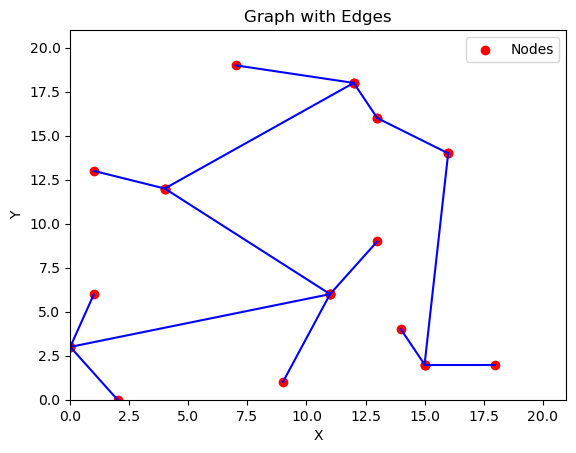

In [1738]:
# These are random nodes within Q1 with domain and range of 0 to 20
nodes = np.array([
    [ 9,  1],
    [13,  9],
    [13, 16],
    [ 1,  6],
    [16, 14],
    [12, 18],
    [ 7, 19],
    [18,  2],
    [ 1, 13],
    [ 2,  0],
    [ 0,  3],
    [ 4, 12],
    [14,  4],
    [11,  6],
    [15,  2]
])

edges = gen_edges(nodes, 1)
# print(edges)

# Extract the coordinates from the edges
x_coords = [coord[0] for edge in edges for coord in edge]
y_coords = [coord[1] for edge in edges for coord in edge]

# Create a scatter plot of the nodes
plt.scatter(x_coords, y_coords, color='red', label='Nodes')

# Plot the edges
for edge in edges:
    x = [edge[0][0], edge[1][0]]
    y = [edge[0][1], edge[1][1]]
    plt.plot(x, y, color='blue')

# Set the plot limits and labels
plt.xlim(0, 21)
plt.ylim(0, 21)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graph with Edges')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Agent 1 trajectory:
[18, 2]
[15, 2]
[16, 14]
[13, 16]
[12, 18]
[4, 12]
[11, 6]
[9, 1]

Agent 2 trajectory:
[1, 6]
[0, 3]
[11, 6]
[4, 12]
[12, 18]
[13, 16]
[16, 14]
[15, 2]
[14, 4]



/tmp/ipykernel_4062/190011281.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trajectories = np.array([[[18,2], [15,2], [16, 14], [13, 16], [12, 18], [4, 12], [11, 6], [9,1]],


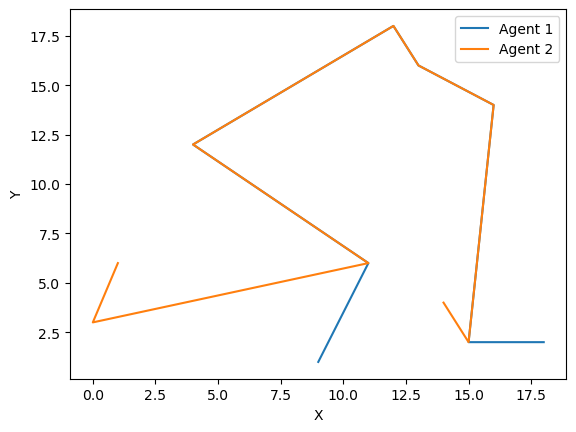

In [1739]:
# Set Up Parameters
s_nodes = np.array([[18, 2], [1, 6]])
g_nodes = np.array([[9, 1], [14, 4]])
# print(edges)
trajectories = np.array([[[18,2], [15,2], [16, 14], [13, 16], [12, 18], [4, 12], [11, 6], [9,1]],
                        [[1, 6], [0, 3], [11, 6], [4, 12], [12, 18], [13, 16], [16, 14], [15, 2], [14, 4]]])

# Generate path
# trajectories = find_path(s_nodes, g_nodes, edges)
# print(trajectories)
for i, trajectory in enumerate(trajectories):
    print(f"Agent {i + 1} trajectory:")
    if trajectory is not None:
        for edge in trajectory:
            print(edge)
    else:
        print("No path found for this agent.")
    print()

# Plot the trajectories
for i, trajectory in enumerate(trajectories):
    x = [point[0] for point in trajectory]
    y = [point[1] for point in trajectory]
    plt.plot(x, y, label=f"Agent {i+1}")

# Add labels and legend
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

# Show the plot
plt.show()

In [1740]:
t1 = np.linspace(0, 1, len(coordinates1), endpoint = False)
t2 = np.linspace(0, 1, len(coordinates2), endpoint = False)
n = 10
ctrlpts1, fitted1 = fit_OLS(t1, coordinates1, n)
ctrlpts2, fitted2 = fit_OLS(t2, coordinates2, n)

/tmp/ipykernel_4062/716767462.py:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)   # Length (N * ndim)


In [1741]:
# Create an instance of the Graph class
# g = Graph()
# uncertainty = 1   


# Add edges to the graph from the TPG data
# tpg_data = sample_tpg_2()
# tpg_data = sample_tpg_h16() 

# g.addEdgesFromTPG(tpg_data)

# Perform DFS and check if the TPG contains cycles
# g.DFSAll()

# Generate control points

# print(tpg_data)

# coordinates1 = np.array([[0,2], [7,3],[11,19]])       # sample_tpg_2 agent 1
# coordinates2 = np.array([[17,5],[7,3],[-3,-14],[-3,-14]])   # sample_tpg_2 agent 2

# coordinates1 = np.array([[-1, 3], [5, -7], [2, 3], [10, 4], [-5, -2]])
# coordinates2 = np.array([[5, -7], [2, 3], [4,1], [2, 3], [10, 4]])

# t1 = np.linspace(0, 1, len(coordinates1), endpoint = False)
# t2 = np.linspace(0, 1, len(coordinates2), endpoint = False)
# n = 10
# ctrlpts1, fitted1 = fit_OLS(t1, coordinates1, n)
# ctrlpts2, fitted2 = fit_OLS(t2, coordinates2, n)


Control Points for Agent 1: [[ -1.           3.        ]
 [ 24.91006666 -18.94451372]
 [  3.68736659 -11.5888484 ]
 [-20.20832655   4.61037153]
 [ -7.26164827  12.79171651]
 [ 27.2280885    9.5252814 ]
 [ 32.46241071   1.78835229]
 [ -2.57539297  -4.11000415]
 [-30.11700697  -5.28869122]
 [-18.40680946  -2.43000884]]


Text(0, 0.5, 'Y')

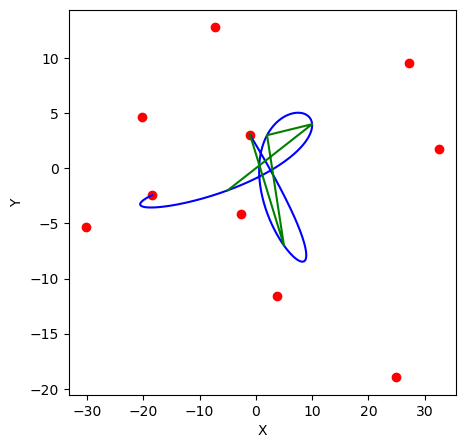

In [1742]:
print('Control Points for Agent 1:', ctrlpts1)

# Plot for Agent 1

fig, ax1 = plt.subplots(1, figsize=(5, 5))

# Plot fitted
ax1.plot(fitted1[:, 0], fitted1[:, 1], color='blue')

# Plot true points
ax1.plot(coordinates1[:, 0], coordinates1[:, 1], color='green')

# Plot control points
ax1.scatter(ctrlpts1[:, 0], ctrlpts1[:, 1], color='red')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')

Control Points for Agent 2: [[ 5.         -7.        ]
 [-7.60138653  9.87467682]
 [ 2.86439268  5.22702968]
 [13.5105189  -2.66579721]
 [ 7.71320683 -3.30594016]
 [-6.90362487  2.75049903]
 [-7.15805515  7.16680842]
 [10.77404193  5.98217169]
 [22.16431148  2.48661535]
 [11.95590984  0.43599498]]


Text(0, 0.5, 'Y')

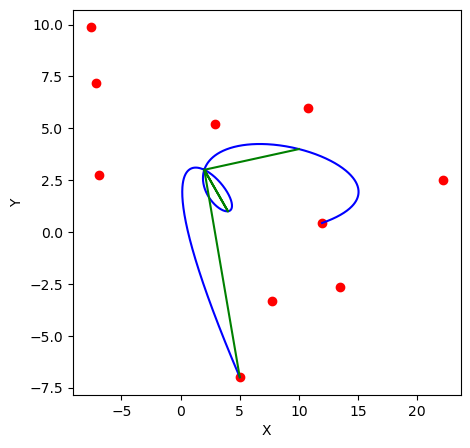

In [1743]:
print('Control Points for Agent 2:', ctrlpts2)

# Plot for Agent 2

fig, ax1 = plt.subplots(1, figsize=(5, 5))

# Plot fitted
ax1.plot(fitted2[:, 0], fitted2[:, 1], color='blue')

# Plot true points
ax1.plot(coordinates2[:, 0], coordinates2[:, 1], color='green')

# Plot control points
ax1.scatter(ctrlpts2[:, 0], ctrlpts2[:, 1], color='red')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')